# Data Description

## Data Source

* PUBG Match Deaths and Statistics, Kaggle 
    \- https://www.kaggle.com/skihikingkevin/pubg-match-deaths

## Data Introduction

In this Kaggle Dataset, over 720,000 competitive matches from the popular game PlayerUnknown's Battlegrounds. The data was extracted from pubg.op.gg, a game tracker website.


### PlayerUnknown's Battlegrounds

PUBG is a first/third-person shooter battle royale style game that matches over 90 players on a large island where teams and players fight to the death until one remains. Players are airdropped from an airplane onto the island where they are to scavenge towns and buildings for weapons, ammo, armor and first-aid. Players will then decide to either fight or hide with the ultimate goal of being the last one standing. A bluezone (see below) will appear a few minutes into the game to corral players closer and closer together by dealing damage to anyone that stands within the bluezone and sparing whoever is within the safe zone.


### The Dataset

This dataset provides two zips: aggregate and deaths.

In **deaths**, the files record every death that occurred within the 720k matches. That is, each row documents an event where a player has died in the match.

In **aggregate**, each match's meta information and player statistics are summarized (as provided by pubg). It includes various aggregate statistics such as player kills, damage, distance walked, etc as well as metadata on the match itself such as queue size, fpp/tpp, date, etc.
The uncompressed data is divided into 5 chunks of approximately 2gb each.

### Columns in deaths

1. killed_by: Which weapon is killed
1. killer_name: Killer game id
1. killer_placement: The final ranking of the team where the killer is located
1. killer_position_x: X coordinate of the killer when the killing behavior occurs
1. killer_position_y: Y coordinate of the killer when the killing behavior occurs
1. map: Game Map(Erangel island/ Miramar desert)
1. match_id : Event Unique ID
1. time: When the kill occurs(How many seconds after the game starts)
1. victim_name: The killed game id
1. victim_position_x: X coordinate of the person being killed when the killing occurs
1. victim_position_y: Y coordinate of the killer at the time of the killing behavior

### Columns in aggregate

1. date: Start time of the game
1. game_size: Site size
1. match_id: Event Unique ID
1. match_mode: Game Mode(First/ Third Person View)
1. party_size: Squad size(1person/ 2people/ 4people)
1. player_assists: Rescue teammates
1. player_dbno: Number of times the player was knocked down
1. player_dist_ride: Driving Distance
1. player_dist_walk: Walking distance
1. player_dmg: Injury points
1. player_kills: kills
1. player_name: Player Game id
1. player_survive_time: Player survival time
1. team_id: The player's team number
1. team_placement: The final ranking of the player's team

# 라이브러리 및 데이터 로드

## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.auto import tqdm
tqdm.pandas()
import os

In [2]:
# MAC 기준
# Window font: 'Malgun Gothic'

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 데이터

In [ ]:
data_dir = '../dataset/raw/'

In [ ]:
def data_load(data_dir, name_list, df_list):
    df_list = []
    for i in tqdm(name_list):
        df_list.append(pd.read_csv(data_dir + i))
    return df_list

In [ ]:
agg_data_dir = '../dataset/raw/aggregate/'
agg_name_list = sorted(os.listdir(agg_data_dir))
agg_list = []
agg_list = data_load(agg_data_dir, agg_name_list, agg_list)

In [ ]:
deaths_data_dir = '../dataset/raw/deaths/'
deaths_name_list = sorted(os.listdir(deaths_data_dir))
deaths_list = []
deaths_list = data_load(deaths_data_dir, deaths_name_list, deaths_list)

In [ ]:
def get_shape(df_list):
    for i in df_list:
        print(i.shape)

In [ ]:
get_shape(agg_list)

In [ ]:
get_shape(deaths_list)

# Data preprocessing

## Aggregate의 na 제거

In [ ]:
def df_drop_na(df_list):
    for i in tqdm(range(len(df_list))):
        df_list[i] = df_list[i].dropna()

In [ ]:
df_drop_na(agg_list)

## match_mode 제거
* 모두 'tpp'만 가짐

In [ ]:
def del_col(df_list, col_name):
    for i in tqdm(df_list):
        del i[col_name]

In [ ]:
del_col(agg_list, 'match_mode')

## 두 데이터에서 매칭되지 않는 match_id 제거

In [ ]:
def get_unique_match_id(df_list):
    match_id = []
    for i in df_list:
        match_id += [x for x in i['match_id'].unique()]
    return match_id

In [ ]:
agg_match_id = get_unique_match_id(agg_list)

In [ ]:
len(agg_match_id)

In [ ]:
deaths_match_id = get_unique_match_id(deaths_list)

In [ ]:
agg_mat = set(agg_match_id)
deaths_mat = set(deaths_match_id)

In [ ]:
len(agg_mat), len(deaths_mat), len(agg_mat & deaths_mat)

In [ ]:
get_shape(deaths_list)

In [ ]:
for i in range(len(deaths_list)):
    deaths_list[i] = deaths_list[i][deaths_list[i]['match_id'].isin(agg_match_id)]

In [ ]:
get_shape(deaths_list)

## deaths data na 처리

### map na 처리

In [ ]:
deaths_list[0]['map'].unique()

* map 결측값 대체 가능 여부 확인

In [ ]:
map_na_match_id = []
for i in deaths_list:
    map_na_match_id += [x for x in i.loc[i['map'].isnull(), 'match_id'].unique()]

In [ ]:
E_match_id = []
for i in deaths_list:
    E_match_id += [x for x in i.loc[i['map'] == 'ERANGEL', 'match_id'].unique()]

In [ ]:
M_match_id = []
for i in deaths_list:
    M_match_id += [x for x in i.loc[i['map'] == 'MIRAMAR', 'match_id'].unique()]

* 겹치는 match_id 확인

In [ ]:
map_na_match_id = set(map_na_match_id)
E_match_id = set(E_match_id)
M_match_id = set(M_match_id)

In [ ]:
len(map_na_match_id & E_match_id), len(map_na_match_id & M_match_id), len(E_match_id & M_match_id) 

* 대체 불가능 판단 -> Drop

In [ ]:
get_shape(deaths_list)

### deaths 데이터 na drop

In [ ]:
df_drop_na(deaths_list)

In [ ]:
get_shape(deaths_list)

## Data 병합

* key columns
    * agg.match_id = deaths.match_id
    * agg.player_name = deaths.killer_name

In [ ]:
# key column의 이름을 맞춰야 함
# deaths의 killer_name을 player_name으로 변경

def chg_col_names(df_list, col_names):
    for i in tqdm(df_list):
        i.columns = col_names

In [ ]:
deaths_list[0].columns

In [ ]:
deaths_cols = ['killed_by', 'player_name', 'killer_placement', 'killer_position_x',
               'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
               'victim_placement', 'victim_position_x', 'victim_position_y']

In [ ]:
# key column 이름 맞추기

chg_col_names(deaths_list, deaths_cols)

## Aggregate 데이터와 Deaths 데이터 Merge

* 같은 번호의 데이터와 짝을 이루는 것을 match_id로 확인함
    * e.g. agg_0는 deaths_0과 Merge

In [ ]:
get_shape(agg_list)

In [ ]:
get_shape(deaths_list)

In [ ]:
deaths_list[0]['map'].unique()

In [ ]:
def get_merged_df(left, right, join, keys):
    df_list = []
    for i in tqdm(range(len(left))):
        df_list.append(pd.merge(left[i], right[i], how=join, on=keys))
    return df_list

In [ ]:
df_merge = get_merged_df(agg_list, deaths_list, 'left', ['match_id', 'player_name'])

In [ ]:
get_shape(df_merge)

## map 채우기

In [ ]:
def fill_map_na(df_list, match_id_list, map_name):
    for i in df_list:
        i.loc[(i['match_id'].isin(match_id_list))&(i['map'].isnull()), 'map'] = map_name
    return df_list

In [ ]:
match_id = [E_match_id, M_match_id]
map_names = ['ERANGEL', 'MIRAMAR']

for i in tqdm(range(len(match_id))):
    df_merge = fill_map_na(df_merge, match_id[i], map_names[i])

## map별로 데이터 나누기

* ERANGEL과 MIRAMAR로 데이터 셋을 나눔

In [ ]:
def get_df_map(df_list, map_name):
    df_map = []
    for i in df_list:
        df_map.append(i[i['map'] == map_name])
    return df_map

In [ ]:
df_map  = []
for i in tqdm(range(len(map_names))):
    df_map.append(get_df_map(df_merge, map_names[i]))

## party_size 별로 데이터 나누기

* party_size에 따라 Tier가 다르기 때문에 데이터를 분리함

In [ ]:
def get_df_party_size(df_list, party_size):
    df_party_size = []
    for i in df_list:
        df_party_size.append(i[i['party_size'] == party_size])
    return df_party_size

In [ ]:
df = []
party_size = [1, 2, 4]

for i in tqdm(range(len(party_size))):
    for j in range(len(df_map)):
        df.append(get_df_party_size(df_map[j], party_size[i]))

In [ ]:
# df[0]: solo, ERANGEL / df[1]: solo, MIRAMAR
# df[2]: duo, ERANGEL / df[3]: duo, MIRAMAR
# df[4]: squad, ERANGEL / df[5]: squad, MIRAMAR

len(df)

## party_size별 map별 dataset 합치기

In [ ]:
def get_concat(df_list):
    df_concat = []
    for i in tqdm(range(len(df_list))):
        df_concat.append(pd.concat(df_list[i], ignore_index=True))
    return df_concat

In [ ]:
# df_concat[0]: solo, ERANGEL / df_concat[1]: solo, MIRAMAR
# df_concat[2]: duo, ERANGEL / df_concat[3]: duo, MIRAMAR
# df_concat[4]: squad, ERANGEL / df_concat[5]: squad, MIRAMAR

df_concat = get_concat(df)

## killed_by 그룹핑

In [ ]:
def killed_by_refine(df):
    df['killed_by'] = df['killed_by'].replace({'death.WeapSawnoff_C': 'sawed_off', 
                                               'death.PlayerMale_A_C': 'Punch',
                                               'death.PG117_A_01_C': 'Boat' , 'death.RedZoneBomb_C': 'RedZone'})
    df['killed_by'] = df['killed_by'].replace(['Pickup Truck','Hit by Car','Buggy','Dacia','Motorbike',
                                               'Motorbike (SideCar)','Uaz','Van'], 'land_vehicle')
    df['killed_by'] = df['killed_by'].replace(['death.ProjMolotov_C', 'death.ProjMolotov_DamageField_C', 
                                               'death.Buff_FireDOT_C'], 'Molotov')
    df['killed_by'] = df['killed_by'].replace(['Aquarail','Boat'], 'water_vehicle')

In [ ]:
for i in tqdm(df_concat):
    killed_by_refine(i)

## csv로 내보내기

In [ ]:
def df_read_csv(df_list, data_dir, file_name):
    for i in tqdm(range(len(df_list))):
        df_list[i].to_csv(data_dir + f'{file_name[i]}.csv', index=False)

# Bug player 처리

In [ ]:
data_dir = '../dataset/preprocessing/'

df = pd.read_csv(data_dir + 'squad_E.csv')

In [ ]:
df_raw = df.copy()

In [ ]:
class CheckingBugPlayer:
    
    '''
    Bug Player 처리를 위한 Class 입니다.
    아래의 기준 중 하나라도 만족하는 player는 Bug player로 지정합니다.
    
    dist_ride : 30000(30km) 초과
    dist_walk : 10000(10km) 초과
    kills :     30 kill 초과
    dmg :       3000 damage 초과
    kill_dist : 40000(400m) 초과
    dbno :      11 초과
    survive_time : 1900 초과
    
    '''
    
        
    def player_dist_ride(self, df):
        df.loc[df['player_dist_ride'] > 30000, 'outlier'] = 1
        return df
    
    def player_dist_walk(self, df):
        df.loc[df['player_dist_walk'] > 10000, 'outlier'] = 1
        return df
        
    def player_kills(self, df):
        df.loc[df['player_kills'] > 30, 'outlier'] = 1
        return df
    
    def player_dmg(self, df):
        df.loc[df['player_dmg'] > 3000, 'outlier'] = 1 
        return df
        
    def kill_dist(self, df):
        df['kill_dist'] = np.sqrt(((df['killer_position_x'] - df['victim_position_x']) ** 2) 
                                      + ((df['killer_position_y'] - df['victim_position_y']) ** 2))
        df['kill_dist'] = df['kill_dist'].fillna(0)
        df.loc[df['kill_dist'] > 40000, 'outlier'] = 1
        return df    
    
    def player_dbno(self, df):
        df.loc[df['player_dbno'] > 11, 'outlier'] = 1
        return df
    
    def player_survive_time(self, df):
        df.loc[df['player_survive_time'] > 1900, 'outlier'] = 1
        return df


## Bug player 처리

In [ ]:
checker = CheckingBugPlayer()

df = checker.player_dist_ride(df)
df = checker.player_dist_walk(df)
df = checker.player_kills(df)
df = checker.player_dmg(df)
df = checker.kill_dist(df)
df = checker.player_dbno(df)
df = checker.player_survive_time(df)

df['outlier'] = df['outlier'].fillna(0)

In [ ]:
df['outlier'].value_counts()

## 분석 Dataset 확인

In [ ]:
df.describe()

In [ ]:
df_outlier = df.copy()

# 파생변수 생성 1

In [ ]:
class DerivingVariables:
    
    '''
    파생변수를 만드는 Class 입니다.
    아래의 방법으로 파생변수를 생성하였습니다.
    
    date         : dtype을 datetime 으로 변환
    score        : (rank_point * 1) + (kill * 2) + (assist * 2)
    tier         : score column을 바탕으로 구함. squad의 +0.6은 위치를 맞추기 위한 수평이동
    KDA          : kill, assist, death를 이용해 파생변수 생성 
                   death는 match 합계에서 team_placement가 1등인 횟수를 제외하여 계산
    num_of_match : player별 총 게임 횟수를 계산
    
    '''
    
    def date(self, df):
        df.loc[:, 'date'] = pd.to_datetime(df['date'])
        return df
    
    def score(self, df):
        max_team_placement = df.groupby(['date', 'match_id'])['team_placement'].max().reset_index()
        max_team_placement.columns = ['date', 'match_id', 'max_placement']
        df = pd.merge(df, max_team_placement, how='left', on=['date', 'match_id'])
        
        df['each_game_score'] = (df['max_placement'] - df['team_placement'])*0.1 + np.log(df['player_dmg'] + 1) + df['player_dbno']*(-0.1)
        
        # score의 sum 
        each_score = df.groupby(['player_name', 'date', 'match_id'])['each_game_score'].mean().to_frame()
        total_score = each_score.groupby('player_name')['each_game_score'].sum().to_frame()
        total_score.columns = ['total_score']
        df['total_score'] = total_score.loc[df['player_name'], 'total_score'].values
        
        return df
    
    def kda_num_of_match(self, df):
        # 필요한 column 만 추출
        anal_col = df[['player_name', 'match_id','team_placement', 'player_kills', 'player_assists']]

        # num_of_match
        num_of_match = anal_col.groupby('player_name')['match_id'].nunique().reset_index()
        num_of_match.columns = ['player_name', 'num_of_match']

        # num_of_1st
        num_of_1st = anal_col[anal_col['team_placement'] == 1].groupby('player_name')['match_id'].nunique().reset_index()
        num_of_1st.columns = ['player_name', 'num_of_1st']

        # death 
        temp = num_of_match.merge(num_of_1st, how = 'left', on = 'player_name')
        temp = temp.fillna(0)
        temp.loc[:, 'deaths_sum'] = temp['num_of_match'] - temp['num_of_1st']
        death = temp[['player_name', 'deaths_sum']]

        # kill & assist
        KA_count = anal_col.groupby(['player_name', 'match_id'])[['player_kills', 'player_assists']].mean().reset_index()
        KA_sum = KA_count.groupby('player_name')[['player_kills', 'player_assists']].sum().reset_index()
        KA_sum.columns = ['player_name', 'kills_sum', 'assists_sum']

        # KDA
        KDA = KA_sum.merge(death, how = 'left', on = 'player_name')
        KDA.loc[:, 'kda'] = (KDA['kills_sum'] + KDA['assists_sum']) / KDA['deaths_sum']
        KDA_1 = KDA[['player_name', 'kda']]


        ## 여기 한번에 표현 할 수 있는가
        df = df.merge(KDA_1, how='left', on='player_name')
        df = df.merge(num_of_match, how='left', on='player_name' )

        return df

## 파생변수1 생성

In [ ]:
variables = DerivingVariables()

df = variables.date(df)

In [ ]:
df = variables.score(df)

In [ ]:
df = variables.kda_num_of_match(df)

In [ ]:
df_var1 = df.copy()

# 파생변수 생성 2

In [ ]:
class DerivingVariables2:
    """
    
    
    """
    
    def date_vars(self, df):
        df['kor_date'] = df['date'] + datetime.timedelta(hours=9)
        df['day_of_week'] = df['kor_date'].dt.weekday
        df['weekend'] = [1 if x >= 6 else 0 for x in df['day_of_week'] ]
        df['date_time'] = df['kor_date'].dt.hour

        def get_time_zone(time):
            if time <= 4 :
                return 'peak time'
            elif time <= 10 :
                return 'morning'
            elif time <= 16 :
                return 'afternoon'
            elif time <= 22 :
                return 'evening'
            else:
                return 'peak time'

        df['time_zone'] = df['date_time'].apply(lambda x: get_time_zone(x))

        return df

    def weapon_category(self, df):

        accident = ['water_vehicle', 'land_vehicle', 'Falling', 'Drown', 'RedZone', 'Bluezone']
        short = ['P18C', 'R1895', 'P92', 'P1911', 'S686', 'S1897', 'S12K', 'Sickle', 'Machete', 'Pan', 'Punch', 
                 'Crowbar', 'Crossbow']
        middle = ['UMP9', 'Micro UZI', 'Tommy Gun', 'Vector', 'AUG', 'Groza', 'M249', 'DP-28']
        long = ['SKS', 'Mini 14', 'VSS', 'Mk14', 'Kar98k', 'M24', 'AWM']
        throwables = ['Molotov', 'Grenade']


        def get_weapon(weapon):
            if weapon in accident :
                return 'accident'
            elif weapon in short:
                return 'short_range'
            elif weapon in middle:
                return 'middle_range'
            elif weapon in long:
                return 'long_range'
            elif weapon in throwables:
                return 'throwables'
            else:
                return weapon
        
        df['weapon'] = df['killed_by'].apply(lambda x: get_weapon(x))
        
        return df

    def dmg_per_kills(self, df):
        df['dmg_per_kills'] = df['player_dmg'] / df['player_kills']
        df.loc[(df['player_dmg'] == 0) & (df['player_kills'] != 0), 'dmg_per_kills'] = 0
        idx = df[df['dmg_per_kills'] == np.inf].index
        df.loc[idx, 'dmg_per_kills'] = df.loc[idx, 'player_dmg'] / 100000
        return df
    
    def ride_ratio(self, df):
        df['ride_ratio'] = df['player_dist_ride'] / df['player_dist_walk']
        df.loc[(df['player_dist_ride'] > 0) & (df['player_dist_walk'] == 0), 'ride_ratio'] = 10000
        return df

    def cumulative_sum(self, df):
        df_cum_grp = df.groupby(['date', 'match_id', 'player_name'])[['each_game_score', 'player_kills', 
                                                                          'player_dmg', 'player_assists',
                                                                          'dmg_per_kills', 
                                                                          'ride_ratio']].mean().reset_index()
        df_cum_grp['num'] = 1

        df_cum_sum = df_cum_grp.groupby('player_name').cumsum()

        df_cum_last = df_cum_sum.copy()
        for col in range(df_cum_sum.shape[1]):
            df_cum_last.iloc[:, col] = df_cum_sum.iloc[:, col] - df_cum_grp.iloc[:, col + 3]
        df_cum_last.columns = ['cum_each_game_score', 'cum_player_kills', 'cum_player_dmg', 'cum_player_assists', 
                               'dmg_kills', 'ride_walk', 'cum_num']

        df_cum = pd.concat([df_cum_grp, df_cum_last], axis=1)
        df_cum_m = df_cum[['date', 'match_id', 'player_name', 'cum_each_game_score', 'cum_player_kills', 
                           'cum_player_dmg', 'cum_player_assists', 'cum_num']]

        df = pd.merge(df, df_cum_m, how='left', on=['date', 'match_id', 'player_name'])

        return df

    def match_level(self, df):
        match_player_level = df.groupby(['date', 'match_id', 'player_name'])['cum_each_game_score'].mean().reset_index()

        match_level = match_player_level.groupby(['date', 'match_id'])['cum_each_game_score'].mean().reset_index()
        match_level.columns = ['date', 'match_id', 'match_level']

        df = pd.merge(df, match_level, how='left', on=['date', 'match_id'])

        return df

    def team_level(self, df):
        team_player_level = df.groupby(['date', 'match_id', 'team_id', 'player_name'])['cum_each_game_score'].mean().reset_index()

        match_level = df.groupby(['date', 'match_id'])['cum_each_game_score'].sum().reset_index()
        match_level.columns = ['date', 'match_id', 'match_level_sum']

        team_level_sum = df.groupby(['date', 'match_id', 'team_id'])[['cum_each_game_score', 'cum_num']].sum().reset_index()
        team_level_sum.columns = ['date', 'match_id', 'team_id', 'team_level_sum', 'team_cum_num']

        team_level = pd.merge(team_level_sum, match_level, how='left', on=['date', 'match_id'])
        team_level['team_level'] = team_level['team_level_sum'] / team_level['match_level_sum']

        df = pd.merge(df, team_level, how='left', on=['date', 'match_id', 'team_id'])

        return df

    def first_kill_time(self, df):
        first_kill_time = df.groupby(['date', 'match_id', 'team_id'])[['time']].min().reset_index()
        first_kill_time.columns = ['date', 'match_id', 'team_id', 'first_kill_time']
        df = pd.merge(df, first_kill_time, how='left', on=['date', 'match_id', 'team_id'])


        def get_team_tendency(first_kill_time):
            if first_kill_time <= 125:
                return 6
            elif first_kill_time <= 250:
                return 5
            elif first_kill_time <= 375:
                return 4
            elif first_kill_time <= 500:
                return 3
            elif first_kill_time <= 625:
                return 2
            elif first_kill_time <= 750:
                return 1
            else:
                return 0

        df['tendency'] = df['first_kill_time'].apply(lambda x: get_team_tendency(x))

        return df

    def kill_position(self, df):

        # 강북
        df.loc[((df['killer_position_x'] > 120000) & (df['killer_position_x'] < 240000)) 
           & ((df['killer_position_y'] > 550000) & (df['killer_position_y'] < 600000)), '강북'] = 1
        df['강북'] = df['강북'].fillna(0)

        # 강남
        df.loc[(df['killer_position_x'] > 100000) & (df['killer_position_x'] < 220000)
               & (df['killer_position_y'] > 480000) & (df['killer_position_y'] < 540000), '강남'] = 1
        df['강남'] = df['강남'].fillna(0)

        # 포친키
        df.loc[((df['killer_position_x'] > 330000) & (df['killer_position_x'] < 380000))
               & ((df['killer_position_y'] > 380000) & (df['killer_position_y'] < 420000)), '포친키'] = 1
        df['포친키'] = df['포친키'].fillna(0)

        # 야스나야
        df.loc[((df['killer_position_x'] > 500000) & (df['killer_position_x'] < 570000))
               & ((df['killer_position_y'] > 540000) & (df['killer_position_y'] < 600000)), '야스나야'] = 1
        df['야스나야'] = df['야스나야'].fillna(0)

        # 프리모스크
        df.loc[((df['killer_position_x'] > 140000) & (df['killer_position_x'] < 180000))
               & ((df['killer_position_y'] > 170000) & (df['killer_position_y'] < 220000)), '프리모스크'] = 1
        df['프리모스크'] = df['프리모스크'].fillna(0)

        # 밀리터리베이스
        df.loc[((df['killer_position_x'] > 520000) & (df['killer_position_x'] < 580000))
               &((df['killer_position_y'] > 160000) & (df['killer_position_y'] < 195000)), '밀리터리베이스'] = 1
        df['밀리터리베이스'] = df['밀리터리베이스'].fillna(0)

        # 밀타
        df.loc[((df['killer_position_x'] > 560000) & (df['killer_position_x'] < 610000))
               & ((df['killer_position_y'] > 310000) & (df['killer_position_y'] < 350000)), '밀타'] = 1
        df['밀타'] = df['밀타'].fillna(0)

        # 밀타파워
        df.loc[((df['killer_position_x'] > 700000) & (df['killer_position_x'] < 730000))
               & ((df['killer_position_y'] > 350000) & (df['killer_position_y'] < 400000)), '밀타파워'] = 1
        df['밀타파워'] = df['밀타파워'].fillna(0)

        # 노보(무역항)
        df.loc[((df['killer_position_x'] > 580000) & (df['killer_position_x'] < 630000))
               & ((df['killer_position_y'] > 180000) & (df['killer_position_y'] < 230000)), '노보'] = 1
        df['노보'] = df['노보'].fillna(0)

        # 리포브카
        df.loc[((df['killer_position_x'] > 680000) & (df['killer_position_x'] < 710000))
               & ((df['killer_position_y'] > 450000) & (df['killer_position_y'] < 490000)), '리포브카'] = 1
        df['리포브카'] = df['리포브카'].fillna(0)

        # 로족
        df.loc[((df['killer_position_x'] > 380000) & (df['killer_position_x'] < 420000))
               & ((df['killer_position_y'] > 500000) & (df['killer_position_y'] < 530000)), '로족'] = 1
        df['로족'] = df['로족'].fillna(0)

        # 자키
        df.loc[((df['killer_position_x'] > 100000) & (df['killer_position_x'] < 140000))
               & ((df['killer_position_y'] > 650000) & (df['killer_position_y'] < 690000)), '자키'] = 1
        df['자키'] = df['자키'].fillna(0)

        # 서버니
        df.loc[((df['killer_position_x'] > 360000) & (df['killer_position_x'] < 390000))
               & ((df['killer_position_y'] > 660000) & (df['killer_position_y'] < 690000)), '서버니'] = 1
        df['서버니'] = df['서버니'].fillna(0)

        # 스타버
        df.loc[((df['killer_position_x'] > 550000) & (df['killer_position_x'] < 580000))
               & ((df['killer_position_y'] > 660000) & (df['killer_position_y'] < 680000)), '스타버'] = 1
        df['스타버'] = df['스타버'].fillna(0)

        # 스쿨
        df.loc[((df['killer_position_x'] > 410000) & (df['killer_position_x'] < 440000))
               & ((df['killer_position_y'] > 460000) & (df['killer_position_y'] < 490000)), '스쿨'] = 1
        df['스쿨'] = df['스쿨'].fillna(0)

        # 통곡의다리1
        df.loc[((df['killer_position_x'] > 320000) & (df['killer_position_x'] < 370000))
               & ((df['killer_position_y'] > 210000) & (df['killer_position_y'] < 290000)), '통곡의다리1'] = 1
        df['통곡의다리1'] = df['통곡의다리1'].fillna(0)

        # 통곡의다리2
        df.loc[((df['killer_position_x'] > 530000) & (df['killer_position_x'] < 560000))
               & ((df['killer_position_y'] > 200000) & (df['killer_position_y'] < 310000)), '통곡의다리2'] = 1
        df['통곡의다리2'] = df['통곡의다리2'].fillna(0)

        return df

## 파생변수2 생성

In [ ]:
import datetime

In [ ]:
df = df.sort_values(['date', 'match_id'])

In [ ]:
var = DerivingVariables2()

df = var.date_vars(df)
df = var.weapon_category(df)

In [ ]:
df = var.dmg_per_kills(df)
df = var.ride_ratio(df)

In [ ]:
df = var.cumulative_sum(df)
df = var.match_level(df)

In [ ]:
df = var.team_level(df)
df = var.first_kill_time(df)
df = var.kill_position(df)

In [ ]:
df.loc[df['weapon'] == 'Down and Out', 'Down_and_Out'] = 1
df.loc[df['weapon'] == 'M416', 'M416'] = 1
df.loc[df['weapon'] == 'M16A4', 'M16A4'] = 1
df.loc[df['weapon'] == 'SCAR-L', 'SCAR-L'] = 1
df.loc[df['weapon'] == 'AKM', 'AKM'] = 1
df.loc[df['weapon'] == 'short_range', 'short_range'] = 1
df.loc[df['weapon'] == 'middle_range', 'middle_range'] = 1
df.loc[df['weapon'] == 'long_range', 'long_range'] = 1
df.loc[df['weapon'] == 'accident', 'accident'] = 1
df.loc[df['weapon'] == 'throwables', 'throwables'] = 1

In [ ]:
df[['Down_and_Out', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 'accident', 
    'throwables']] = df[['Down_and_Out', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 
                         'long_range', 'accident', 'throwables']].fillna(0)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head()

In [ ]:
df_var2 = df.copy()

# Column 정리

In [ ]:
df.columns

In [ ]:
del_cols = ['date', 'game_size', 'max_placement', 'party_size', 'killed_by', 'killer_placement', 
            'killer_position_x', 'killer_position_y', 'map', 'time', 'victim_name', 'victim_placement', 
            'victim_position_x', 'victim_position_y', 'weapon']

In [ ]:
for col in del_cols:
    del df[col]

In [ ]:
df.head()

In [ ]:
df_top10 = df.copy()

## csv로 내보내기

In [ ]:
df.to_csv('../dataset/top_10_2.csv', index=False)

In [ ]:
# df.info()

# Feature 결정

In [ ]:
df = pd.read_csv('../dataset/top_10_2.csv')

In [ ]:
def top10(placement):
    if placement < 4:
        return 1
    else:
        return 0

In [ ]:
df['top10'] = df['team_placement'].apply(lambda x: top10(x))

In [ ]:
df.groupby(['kor_date', 'match_id', 'team_id'])['top10'].mean().value_counts().plot.bar()

In [ ]:
df.groupby(['kor_date', 'match_id', 'team_id'])['top10'].mean().value_counts()

In [ ]:
801154/6365210

## Column 분류하기

**1. placement**
* team_placement
* top10

**2. kill/damage/assist**
* player_assists
* player_dbno
* player_dmg
* player_kills
* kda
* dmg_per_kills
* each_game_score
* total_score
* cum_each_game_score
* cum_player_kills
* cum_player_dmg
* cum_player_assists
* match_level
* match_level_sum
* team_level
* team_level_sum

**3. bug player**
* outlier

**4. play_count**
* num_of_match
* cum_num
* team_cum_num

**5. distance**
* player_dist_ride
* player_dist_walk
* ride_ratio

**6. position**
* kill_dist
* 강북
* 강남
* 포친키
* 야스나야
* 프리모스크
* 밀리터리베이스
* 밀타
* 밀타파워
* 노보
* 리포브카
* 로족
* 자키
* 서버니
* 스타버
* 스쿨
* 통곡의다리1
* 통곡의다리2

**7. time**
* player_survive_time
* first_kill_time
* tendency

**8. weapon**
* Down_and_Out
* M416
* M16A4
* SCAR-L
* AKM
* short_range
* middle_range
* long_range
* accident
* throwables

**9. date**
* kor_date
* day_of_week
* weekend
* date_time
* time_zone

**10. game info**
* match_id
* team_id
* player_name

## 추가 변수 생성

* 누적 합
    - outlier였던 횟수
    - position_cols 횟수
    - weapon_cols 횟수
    - first_kill_time
    - each_game_score
    - player_dist_ride
    - player_dist_walk

In [ ]:
cum_sum = ['outlier', '강북', '강남', '포친키', '야스나야', '프리모스크', '밀리터리베이스', '밀타', '밀타파워', '노보', '리포브카',
           '로족', '자키', '서버니', '스타버', '스쿨', '통곡의다리1', '통곡의다리2', 'Down_and_Out', 'M416', 'M16A4', 
           'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 'accident', 'throwables']
cum_mean = ['first_kill_time', 'tendency','player_dist_ride', 'player_dist_walk', 'kill_dist', 
            'ride_ratio', 'dmg_per_kills']

### 누적 합

In [ ]:
df = df.sort_values(['kor_date', 'match_id'])

df_cum_grp = df.groupby(['kor_date', 'match_id', 'player_name'])[cum_sum].mean().reset_index()

df_cum_sum = df_cum_grp.groupby('player_name')[cum_sum].cumsum()

df_cum_last = df_cum_sum.copy()
for col in range(df_cum_sum.shape[1]):
    df_cum_last.iloc[:, col] = df_cum_sum.iloc[:, col] - df_cum_grp.iloc[:, col + 3]
df_cum_last.columns = list(map(lambda x: 'cum_' + x, cum_sum))

df_cum = pd.concat([df_cum_grp, df_cum_last], axis=1)

In [ ]:
df_cum_m = df_cum[['kor_date', 'match_id', 'player_name'] + list(map(lambda x: 'cum_' + x, cum_sum))]

In [ ]:
df = pd.merge(df, df_cum_m, how='left', on=['kor_date', 'match_id', 'player_name'])

### 누적 평균

In [ ]:
df = df.sort_values(['kor_date', 'match_id'])

df_cum_grp = df.groupby(['kor_date', 'match_id', 'player_name'])[cum_mean].mean().reset_index()

df_cum_sum = df_cum_grp.groupby('player_name')[cum_mean].cumsum()

df_cum_last = df_cum_sum.copy()
for col in range(df_cum_sum.shape[1]):
    df_cum_last.iloc[:, col] = df_cum_sum.iloc[:, col] - df_cum_grp.iloc[:, col + 3]
df_cum_last.columns = list(map(lambda x: 'mean_' + x, cum_mean))

df_cum = pd.concat([df_cum_grp, df_cum_last], axis=1)

In [ ]:
df_cum_m = df_cum[['kor_date', 'match_id', 'player_name'] + list(map(lambda x: 'mean_' + x, cum_mean))]

In [ ]:
df = pd.merge(df, df_cum_m, how='left', on=['kor_date', 'match_id', 'player_name'])

In [ ]:
df['mean_first_kill_time'] = df['mean_first_kill_time']/df['cum_num']
df['mean_tendency'] = df['mean_tendency']/df['cum_num']
df['mean_player_dist_ride'] = df['mean_player_dist_ride']/df['cum_num']
df['mean_player_dist_walk'] = df['mean_player_dist_walk']/df['cum_num']
df['mean_dmg_per_kills'] = df['mean_dmg_per_kills']/df['cum_num']
df['mean_ride_ratio'] =  df['mean_ride_ratio']/df['cum_num']
df['mean_kill_dist'] = df['mean_kill_dist']/df['cum_num']

## (Cumulative ver) Feature 결정

In [ ]:
df.columns

In [ ]:
cum_position = ['cum_강북', 'cum_강남', 'cum_포친키', 'cum_야스나야', 'cum_프리모스크', 'cum_밀리터리베이스',
                'cum_밀타', 'cum_밀타파워', 'cum_노보', 'cum_리포브카', 'cum_로족', 'cum_자키',
                'cum_서버니', 'cum_스타버', 'cum_스쿨', 'cum_통곡의다리1', 'cum_통곡의다리2']
cum_weapon = ['cum_Down_and_Out', 'cum_M416', 'cum_M16A4', 'cum_SCAR-L', 'cum_AKM', 'cum_short_range', 
              'cum_middle_range', 'cum_long_range', 'cum_accident','cum_throwables']
level = ['match_level', 'match_level_sum', 'team_level', 'team_level_sum', 'cum_num', 'team_cum_num',
         'cum_each_game_score', 'cum_outlier', 'mean_dmg_per_kills']
mean = ['mean_kill_dist', 'mean_first_kill_time', 'mean_tendency', 'mean_player_dist_walk', 
        'mean_player_dist_ride', 'mean_ride_ratio']

In [ ]:
X_raw = df[['kor_date', 'match_id', 'team_id', 'player_name', 'top10'] + level + mean + cum_weapon + cum_position]

In [ ]:
X = X_raw[['kor_date', 'match_id', 'team_id', 'player_name', 'top10'] 
          + ['match_level', 'tema_level', 'team_cum_num', 'cum_outlier']
          + ['mean_tendency', 'mean_ride_ratio']]

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_F = df.copy()

## Groupby

In [ ]:
df.columns

In [ ]:
df['hot_place'] = df['강북'] + df['강남'] + df['포친키'] + df['야스나야'] + df['프리모스크'] + df['밀리터리베이스'] + df['밀타'] + df['밀타파워'] + df['노보'] + df['리포브카'] + df['로족'] + df['자키']+ df['서버니'] + df['스타버'] + df['스쿨'] + df['통곡의다리1'] + df['통곡의다리2']

In [ ]:
mean_cols = ['top10', 'player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk', 
             'player_dmg', 'player_kills', 'player_survive_time', 'total_score','day_of_week', 'first_kill_time',
             'tendency', 'kill_dist', 'weekend', 'date_time', 'dmg_per_kills', 'ride_ratio','cum_each_game_score', 
             'cum_player_kills', 'cum_player_dmg', 'cum_player_assists', 'cum_num', 'match_level', 
             'team_level_sum', 'team_cum_num', 'match_level_sum', 'team_level']

sum_cols = ['hot_place', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
            'accident', 'throwables']

mean_sum_cols = ['num_of_match']

max_sum_cols = ['outlier']

In [ ]:
df[mean_cols + sum_cols].isnull().sum()

In [ ]:
df['team_level'] = df['team_level'].fillna(0)
df['dmg_per_kills'] = df['dmg_per_kills'].fillna(0)
df['ride_ratio'] = df['ride_ratio'].fillna(0)
df['first_kill_time'] = df['first_kill_time'].fillna(-1) 

In [ ]:
df_m_s['outlier'].value_counts()

In [ ]:
df_m_s_t['outlier'].value_counts()

In [ ]:
df_mean = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[mean_cols].mean().reset_index()

In [ ]:
df_mean_t = df_mean.groupby(['kor_date', 'match_id', 'team_id'])[mean_cols].mean().reset_index()

In [ ]:
df_sum = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[sum_cols].sum().reset_index()

In [ ]:
df_sum_t = df_sum.groupby(['kor_date', 'match_id', 'team_id'])[sum_cols].sum().reset_index()

In [ ]:
num_match = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[mean_sum_cols].mean().reset_index()

In [ ]:
num_match_t = num_match.groupby(['kor_date', 'match_id', 'team_id'])[mean_sum_cols].sum().reset_index()

In [ ]:
outlier = df.groupby(['kor_date', 'match_id', 'team_id', 'player_name'])[max_sum_cols].max().reset_index()

In [ ]:
outlier_t = outlier.groupby(['kor_date', 'match_id', 'team_id'])[max_sum_cols].sum().reset_index()

In [ ]:
df_t = pd.merge(df_mean_t, df_sum_t, how='left', on=['kor_date', 'match_id', 'team_id'])

In [ ]:
df_t = pd.merge(df_t, num_match_t, how='left', on=['kor_date', 'match_id', 'team_id'])

In [ ]:
df_t = pd.merge(df_t, outlier_t, how='left', on=['kor_date', 'match_id', 'team_id'])

In [ ]:
df_t.info()

In [ ]:
outlier['outlier'].value_counts()

In [ ]:
df_t['outlier'].value_counts()

In [ ]:
df_t.to_csv('../dataset/team.csv', index=False)

## Feature 확인

In [20]:
df_t.loc[df_t['top10'] == 1, 'top10'] = 'Top10'
df_t.loc[df_t['top10'] == 0, 'top10'] = 'Not Top10'

### 무기

In [21]:
w = df_t.groupby(['top10'])[['M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
                             'accident', 'throwables']].sum().reset_index()

In [22]:
w2 = pd.melt(w, id_vars='top10')

In [23]:
w2.columns = ['top10', 'weapons', 'counts']

In [24]:
w2

,top10,weapons,counts
0,Not Top10,M416,1533358.000
1,Top10,M416,842361.000
2,Not Top10,M16A4,1530080.000
3,Top10,M16A4,542935.000
4,Not Top10,SCAR-L,1318171.000
5,Top10,SCAR-L,661551.000
6,Not Top10,AKM,1437947.000
7,Top10,AKM,463282.000
8,Not Top10,short_range,3069261.000
9,Top10,short_range,344558.000


<AxesSubplot:xlabel='counts', ylabel='weapons'>

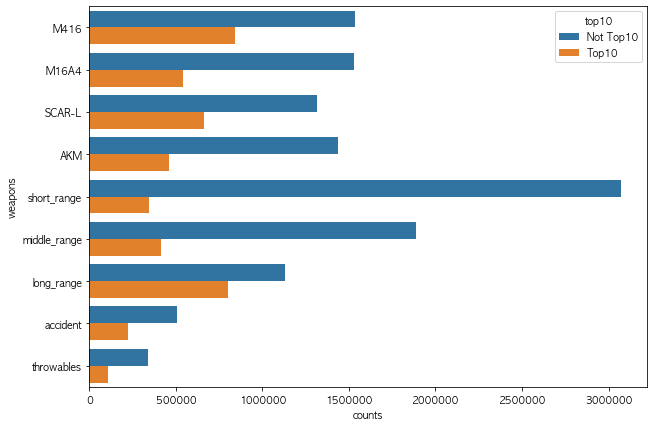

In [17]:
plt.figure(figsize=(10, 7))
plt.ticklabel_format(style='plain')
sns.barplot(data=w2, x='counts', y='weapons', hue='top10', ci=None)

### Outlier

In [30]:
o = df_t.groupby(['kor_date', 'match_id', 'team_id', 'top10'])[['outlier']].mean().reset_index()

In [27]:
o.groupby(['top10'])['outlier'].value_counts(normalize=True)

top10      outlier
Not Top10  0.000     0.917
           1.000     0.077
           2.000     0.005
           3.000     0.000
           4.000     0.000
Top10      0.000     0.666
           1.000     0.164
           2.000     0.060
           3.000     0.056
           4.000     0.055
Name: outlier, dtype: float64

### 요일/시간대

In [31]:
d = df_t.groupby(['kor_date', 'match_id'])[['day_of_week', 'date_time', 'match_level']].mean().reset_index()

In [33]:
def day_of_week(num):
    week = [x for x in '월화수목금토일']
    return week[num]

In [38]:
d['day_of_week'] = d['day_of_week'].astype('int')
d['date_time'] = d['date_time'].astype('int')

In [36]:
d['day_of_week'] = d['day_of_week'].apply(lambda x: day_of_week(x))

In [42]:
d

,kor_date,match_id,day_of_week,date_time,match_level
0,2017-10-20 17:01:07+00:00,2U4GBNA0Yml6KV2X5zKbFWJzGxFNOvOB8zq4gwaVkAyf_p...,금,17,0.000
1,2017-10-20 17:01:47+00:00,2U4GBNA0Ymk-ID_zUziPaMOji_UXwlTUSeMUHmEmfUQLiZ...,금,17,0.000
2,2017-10-20 17:03:30+00:00,2U4GBNA0YmmBg8gn2Uj-2kGqxinW4XmsxwWa7mMZ_4B4yv...,금,17,0.000
3,2017-10-20 17:03:59+00:00,2U4GBNA0YmlEBszzfxUBBnoPcnidsfH-okTvRedswuK0Vv...,금,17,0.000
4,2017-10-20 17:04:07+00:00,2U4GBNA0YmnhUTz5Am57zhOPYGf8pBKvWlCLDlEHcykY-n...,금,17,0.000
...,...,...,...,...,...
267325,2018-01-10 20:45:46+00:00,2U4GBNA0YmkHj1ElQlasEXp2o4lkaK1TS7YNGgQXcGfB8m...,수,20,46.556
267326,2018-01-10 20:50:08+00:00,2U4GBNA0YmkhGAMNLcoVK4tdSyGtbhlzSBpZZ3Mvk4hhFU...,수,20,45.915
267327,2018-01-10 20:51:13+00:00,2U4GBNA0YmmzDCa5OQUnuhNrl101XV6sbZWQTH9qFIBEL8...,수,20,18.440
267328,2018-01-10 20:53:30+00:00,2U4GBNA0YmncIoDjHBmmazW-zU8FH34QHeda1RDAX6gsG1...,수,20,13.401


In [46]:
d.columns = ['날짜', 'match_id', '요일', '시간대', 'match 수준']

<AxesSubplot:xlabel='요일', ylabel='match 수준'>

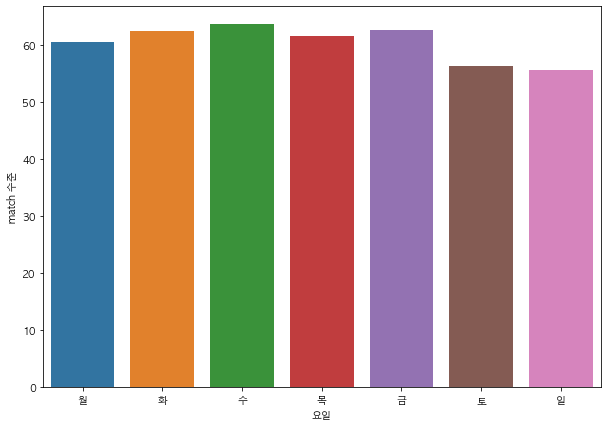

In [49]:
plt.figure(figsize=(10, 7))
sns.barplot(data=d, x='요일', y='match 수준', ci=None, order=[x for x in '월화수목금토일'])

<AxesSubplot:xlabel='시간대', ylabel='match 수준'>

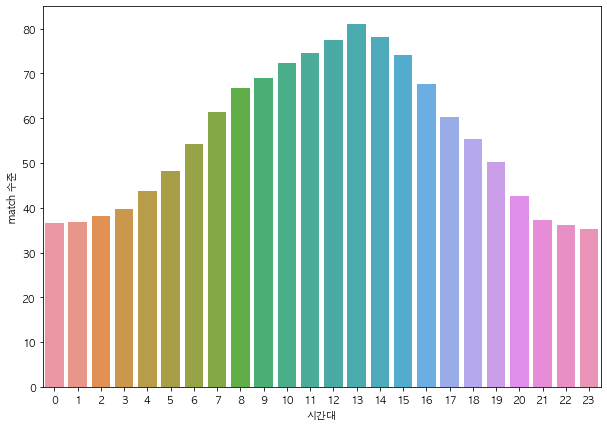

In [51]:
plt.figure(figsize=(10, 7))
sns.barplot(data=d, x='시간대', y='match 수준', ci=None)

### Match/Team level

In [52]:
l = df_t.groupby(['kor_date', 'match_id', 'team_id', 'top10'])[['match_level', 'team_level']].mean().reset_index()

<AxesSubplot:>

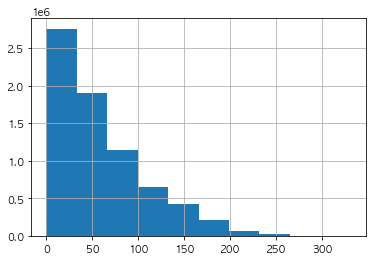

In [53]:
l['match_level'].hist()

In [54]:
def match_level_cat(score):
    if score <= 50:
        return 'Easy'
    elif score <= 100:
        return 'Medium'
    elif score <= 150:
        return 'Hard'
    else:
        return 'X-Hard'

In [55]:
l['match'] = l['match_level'].apply(lambda x: match_level_cat(x))

In [59]:
l

,kor_date,match_id,team_id,top10,match_level,team_level,match
0,2017-10-20 17:01:07+00:00,2U4GBNA0Yml6KV2X5zKbFWJzGxFNOvOB8zq4gwaVkAyf_p...,2,Not Top10,0.000,0.000,Easy
1,2017-10-20 17:01:07+00:00,2U4GBNA0Yml6KV2X5zKbFWJzGxFNOvOB8zq4gwaVkAyf_p...,3,Not Top10,0.000,0.000,Easy
2,2017-10-20 17:01:07+00:00,2U4GBNA0Yml6KV2X5zKbFWJzGxFNOvOB8zq4gwaVkAyf_p...,4,Not Top10,0.000,0.000,Easy
3,2017-10-20 17:01:07+00:00,2U4GBNA0Yml6KV2X5zKbFWJzGxFNOvOB8zq4gwaVkAyf_p...,5,Not Top10,0.000,0.000,Easy
4,2017-10-20 17:01:07+00:00,2U4GBNA0Yml6KV2X5zKbFWJzGxFNOvOB8zq4gwaVkAyf_p...,7,Not Top10,0.000,0.000,Easy
...,...,...,...,...,...,...,...
7166359,2018-01-10 20:54:18+00:00,2U4GBNA0YmmON-6HaqCFBfMmkJHkTe0blndvQBWmYL4mW3...,26,Not Top10,18.548,0.002,Easy
7166360,2018-01-10 20:54:18+00:00,2U4GBNA0YmmON-6HaqCFBfMmkJHkTe0blndvQBWmYL4mW3...,27,Not Top10,18.548,0.000,Easy
7166361,2018-01-10 20:54:18+00:00,2U4GBNA0YmmON-6HaqCFBfMmkJHkTe0blndvQBWmYL4mW3...,28,Not Top10,18.548,0.000,Easy
7166362,2018-01-10 20:54:18+00:00,2U4GBNA0YmmON-6HaqCFBfMmkJHkTe0blndvQBWmYL4mW3...,29,Not Top10,18.548,0.012,Easy


In [60]:
l.columns = ['날짜', 'match_id', 'team_id', 'top10', '매치 수준', '팀 수준', 'match']

<AxesSubplot:xlabel='match', ylabel='팀 수준'>

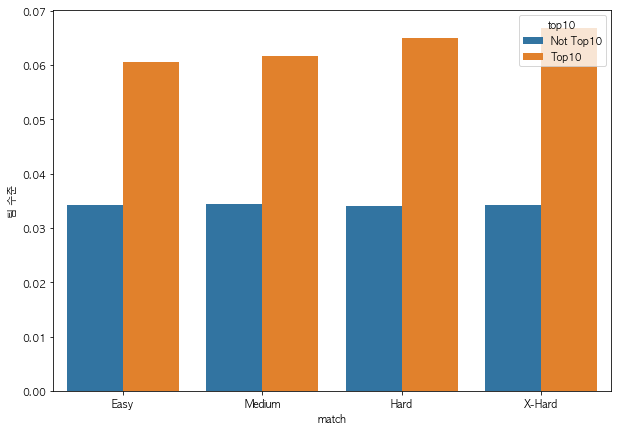

In [61]:
plt.figure(figsize=(10, 7))
sns.barplot(data=l, x='match', y='팀 수준', hue='top10', ci=None)

### dmg_per_kills

In [62]:
l = df_t.groupby(['kor_date', 'match_id', 'team_id', 'top10'])[['dmg_per_kills']].mean().reset_index()

In [63]:
l2 = l.groupby('top10')['dmg_per_kills'].mean().reset_index()

In [66]:
l2.columns = ['top10', '1 kill 당 평균 damage']

In [71]:
l2

,top10,1 kill 당 평균 damage
0,Not Top10,46.897
1,Top10,89.462


<AxesSubplot:xlabel='top10', ylabel='1 kill 당 평균 damage'>

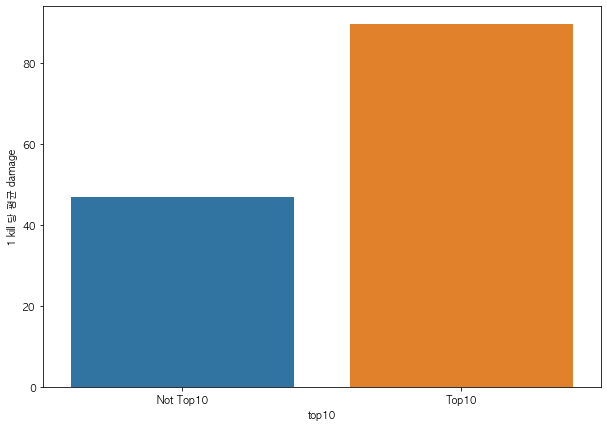

In [70]:
plt.figure(figsize=(10, 7))
sns.barplot(data=l2, x = 'top10', y='1 kill 당 평균 damage', ci=None)

### 탈 것 활용 비율

In [72]:
m = df_t.groupby(['kor_date', 'match_id', 'team_id', 'top10'])[['player_dist_walk', 'player_dist_ride', 
                                                                'ride_ratio']].mean().reset_index()

In [73]:
m.columns = ['날짜', 'match_id', 'team_id', 'top10', '도보 이동 거리', '탈 것 이동 거리', '탈 것 활용 비율']

<AxesSubplot:xlabel='top10', ylabel='도보 이동 거리'>

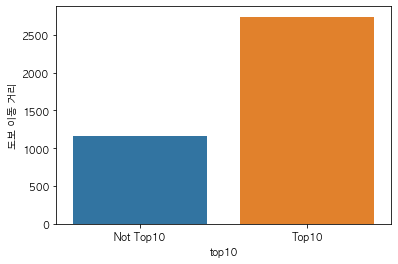

In [85]:
sns.barplot(data=m, x='top10', y='도보 이동 거리', ci=None)

<AxesSubplot:xlabel='top10', ylabel='탈 것 이동 거리'>

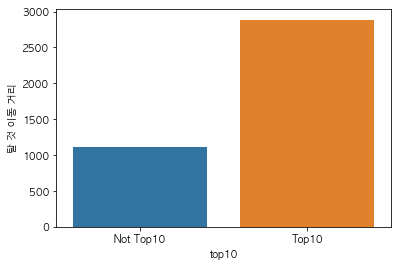

In [75]:
sns.barplot(data=m, x='top10', y='탈 것 이동 거리', ci=None)

<AxesSubplot:xlabel='top10', ylabel='탈 것 활용 비율'>

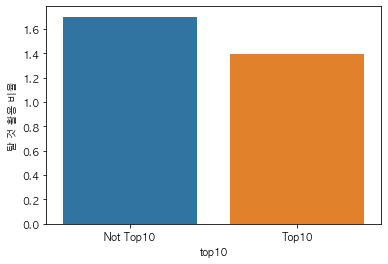

In [76]:
sns.barplot(data=m, x='top10', y='탈 것 활용 비율', ci=None)

In [88]:
m_w = m.groupby('top10')['도보 이동 거리'].median().reset_index()

<AxesSubplot:xlabel='top10', ylabel='도보 이동 거리'>

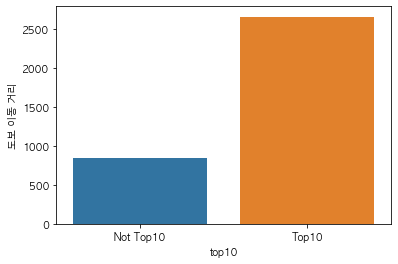

In [89]:
sns.barplot(data=m_w, x='top10', y='도보 이동 거리', ci=None)

In [90]:
m_v = m.groupby('top10')['탈 것 이동 거리'].median().reset_index()

<AxesSubplot:xlabel='top10', ylabel='탈 것 이동 거리'>

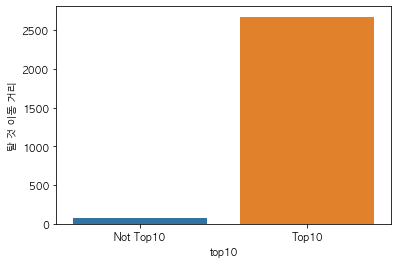

In [91]:
sns.barplot(data=m_v, x='top10', y='탈 것 이동 거리', ci=None)

In [92]:
m_r = m.groupby('top10')['탈 것 활용 비율'].median().reset_index()

<AxesSubplot:xlabel='top10', ylabel='탈 것 활용 비율'>

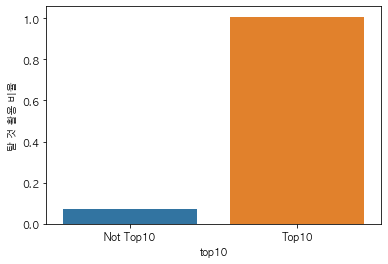

In [94]:
sns.barplot(data=m_r, x='top10', y='탈 것 활용 비율', ci=None)

### 교전 거리

In [95]:
k = df_t.groupby(['top10'])[['kill_dist']].mean().reset_index()

In [96]:
k

,top10,kill_dist
0,Not Top10,10456.241
1,Top10,12414.920


In [99]:
k.columns = ['top10', '교전거리']

<AxesSubplot:xlabel='top10', ylabel='교전거리'>

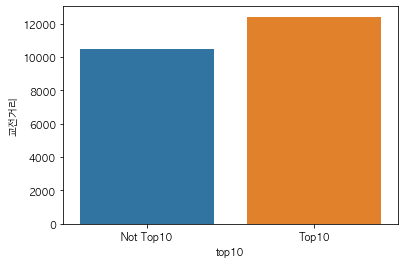

In [100]:
sns.barplot(data=k, x='top10', y='교전거리', ci=None)

In [97]:
k2 = df_t.groupby(['top10'])[['kill_dist']].median().reset_index()

In [98]:
k2

,top10,kill_dist
0,Not Top10,328.558
1,Top10,4033.609


In [101]:
k2.columns = ['top10', '교전거리']

<AxesSubplot:xlabel='top10', ylabel='교전거리'>

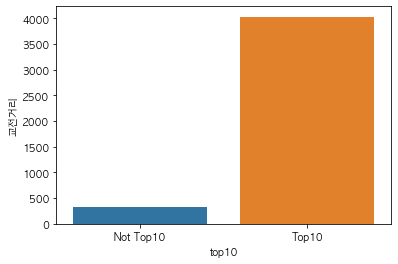

In [102]:
sns.barplot(data=k2, x='top10', y='교전거리', ci=None)

### 호전성

In [103]:
t = df_t.groupby(['kor_date', 'match_id', 'team_id', 'top10'])[['tendency']].mean().reset_index()

In [118]:
t2 = t.groupby('top10')['tendency'].value_counts().sort_index().to_frame()

In [119]:
t2

tendency
top10     tendency          
Not Top10 0.000      2580157
          1.000       190309
          2.000       222565
          3.000       351706
          4.000       636542
          5.000      1638452
          6.000       745479
Top10     0.000       380860
          1.000        36878
          2.000        36758
          3.000        50548
          4.000        76999
          5.000       159805
          6.000        59306

In [120]:
t2.columns = ['counts']

In [122]:
t2 = t2.reset_index()

In [126]:
t2

,top10,tendency,counts
0,Not Top10,0.000,2580157
1,Not Top10,1.000,190309
2,Not Top10,2.000,222565
3,Not Top10,3.000,351706
4,Not Top10,4.000,636542
5,Not Top10,5.000,1638452
6,Not Top10,6.000,745479
7,Top10,0.000,380860
8,Top10,1.000,36878
9,Top10,2.000,36758


In [127]:
t2.columns = ['top10', '호전성', 'counts']

In [130]:
t2['호전성'] = t2['호전성'].astype('int')

In [145]:
t2_1 = t2[t2['호전성'] > 0]

<AxesSubplot:xlabel='top10', ylabel='counts'>

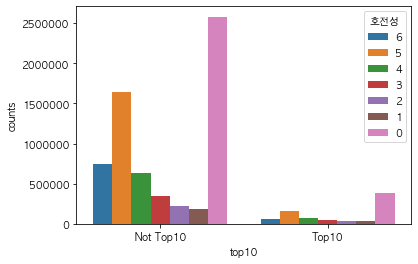

In [144]:
plt.ticklabel_format(style='plain')
sns.barplot(data=t2, x='top10', y='counts', hue='호전성', ci=None, hue_order=[6, 5, 4, 3, 2, 1, 0])

<AxesSubplot:xlabel='top10', ylabel='counts'>

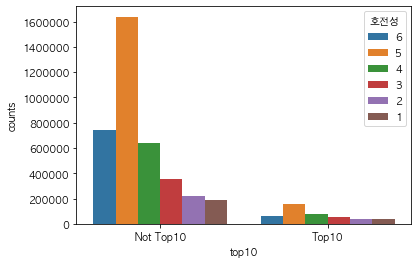

In [147]:
plt.ticklabel_format(style='plain')
sns.barplot(data=t2_1, x='top10', y='counts', hue='호전성', ci=None, hue_order=[6, 5, 4, 3, 2, 1])

# Modeling1 - Undersampling

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [5]:
df_t = pd.read_csv('../dataset/team.csv')

In [6]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7166364 entries, 0 to 7166363
Data columns (total 42 columns):
 #   Column               Dtype  
---  ------               -----  
 0   kor_date             object 
 1   match_id             object 
 2   team_id              int64  
 3   top10                float64
 4   player_assists       float64
 5   player_dbno          float64
 6   player_dist_ride     float64
 7   player_dist_walk     float64
 8   player_dmg           float64
 9   player_kills         float64
 10  player_survive_time  float64
 11  total_score          float64
 12  day_of_week          float64
 13  first_kill_time      float64
 14  tendency             float64
 15  kill_dist            float64
 16  weekend              float64
 17  date_time            float64
 18  dmg_per_kills        float64
 19  ride_ratio           float64
 20  cum_each_game_score  float64
 21  cum_player_kills     float64
 22  cum_player_dmg       float64
 23  cum_player_assists   float64
 24

In [159]:
df_t.columns

Index(['kor_date', 'match_id', 'team_id', 'top10', 'player_assists',
       'player_dbno', 'player_dist_ride', 'player_dist_walk', 'player_dmg',
       'player_kills', 'player_survive_time', 'total_score', 'day_of_week',
       'first_kill_time', 'tendency', 'kill_dist', 'weekend', 'date_time',
       'dmg_per_kills', 'ride_ratio', 'cum_each_game_score',
       'cum_player_kills', 'cum_player_dmg', 'cum_player_assists', 'cum_num',
       'match_level', 'team_level_sum', 'team_cum_num', 'match_level_sum',
       'team_level', 'hot_place', 'M416', 'M16A4', 'SCAR-L', 'AKM',
       'short_range', 'middle_range', 'long_range', 'accident', 'throwables',
       'num_of_match', 'outlier'],
      dtype='object')

## Data for Modeling

In [160]:
weapon = ['M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range', 'middle_range', 'long_range', 
          'accident','throwables']
level = ['match_level', 'match_level_sum', 'team_level', 'team_level_sum', 'cum_num', 'team_cum_num',
         'each_game_score', 'outlier', 'dmg_per_kills']

In [161]:
X = df_t[['day_of_week', 'date_time'] 
         + ['match_level', 'team_level', 'team_cum_num', 'outlier', 'dmg_per_kills', 'hot_place']
         + ['kill_dist', 'tendency', 'ride_ratio'] 
         + weapon]

In [162]:
Y = df_t['top10']

In [163]:
Y.value_counts()

0.000    6365210
1.000     801154
Name: top10, dtype: int64

### Undersampling

* Data: imbalance(0: 88%, 1: 12%)
* 데이터의 크기가 너무 크기 때문에 Undersampling 방법 선택

### train/test dataset

In [164]:
test_idx = X.sample(frac=0.3, random_state=42).index
train_idx = (X.index.isin(test_idx) == False)

In [165]:
train_x = X.loc[train_idx]
test_x = X.loc[test_idx]
train_y = Y[train_idx]
test_y = Y[test_idx]

In [166]:
train_y.value_counts()

0.000    4455536
1.000     560919
Name: top10, dtype: int64

In [167]:
idx_0 = train_y[train_y == 0].sample(n=560919, random_state=42).index

In [168]:
train_x = pd.concat([train_x.loc[idx_0], train_x.loc[train_y==1]])
train_y = pd.concat([train_y.loc[idx_0], train_y.loc[train_y==1]])

In [169]:
train_x.shape, train_y.shape

((1121838, 20), (1121838,))

In [16]:
# train_x, test_x, train_y, test_y = train_test_split(X_new, Y_new, test_size=0.3, random_state=42, stratify=Y_new)

In [170]:
train_y.value_counts(normalize=True)

0.000   0.500
1.000   0.500
Name: top10, dtype: float64

## Model fitting

In [173]:
params ={'n_estimators':[3, 4, 5, 10],
         'max_depth':[7, 8, 9, 10, 12, 14],
         'min_samples_leaf':[12, 15, 18]
}

In [174]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1, scoring='recall')
grid_cv.fit(train_x, train_y)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10, 12, 14],
                         'min_samples_leaf': [12, 15, 18],
                         'n_estimators': [3, 4, 5, 10]},
             scoring='recall')

In [175]:
grid_cv.best_params_

{'max_depth': 7, 'min_samples_leaf': 12, 'n_estimators': 10}

In [188]:
score = grid_cv.cv_results_['mean_test_score'].tolist()

In [189]:
score = pd.DataFrame(score)

In [199]:
score.columns = ['test recalls']

<AxesSubplot:>

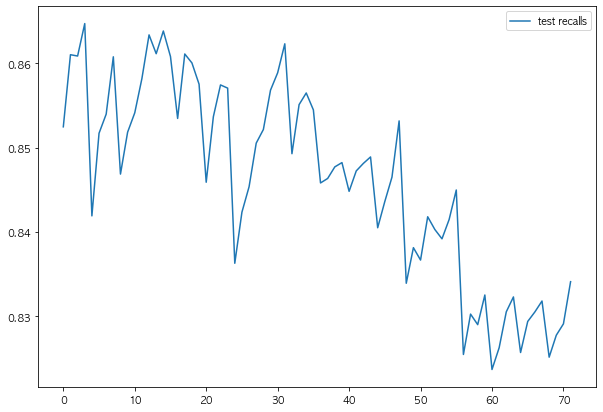

In [200]:
plt.figure(figsize=(10, 7))
sns.lineplot(data = score)

In [201]:
grid_cv.cv_results_['params']

[{'max_depth': 7, 'min_samples_leaf': 12, 'n_estimators': 3},
 {'max_depth': 7, 'min_samples_leaf': 12, 'n_estimators': 4},
 {'max_depth': 7, 'min_samples_leaf': 12, 'n_estimators': 5},
 {'max_depth': 7, 'min_samples_leaf': 12, 'n_estimators': 10},
 {'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 3},
 {'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 4},
 {'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 5},
 {'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 10},
 {'max_depth': 7, 'min_samples_leaf': 18, 'n_estimators': 3},
 {'max_depth': 7, 'min_samples_leaf': 18, 'n_estimators': 4},
 {'max_depth': 7, 'min_samples_leaf': 18, 'n_estimators': 5},
 {'max_depth': 7, 'min_samples_leaf': 18, 'n_estimators': 10},
 {'max_depth': 8, 'min_samples_leaf': 12, 'n_estimators': 3},
 {'max_depth': 8, 'min_samples_leaf': 12, 'n_estimators': 4},
 {'max_depth': 8, 'min_samples_leaf': 12, 'n_estimators': 5},
 {'max_depth': 8, 'min_samples_leaf': 12, 'n_estimators': 10},
 {'m

In [209]:
forest_clf = RandomForestClassifier(random_state=42, max_depth=7, min_samples_leaf=12, n_estimators=10)

In [21]:
forest_clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=7, min_samples_leaf=12, n_estimators=10,
                       random_state=42)

In [82]:
forest_clf.estimators_

[DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=787846414),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=996406378),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                        random_state=423734972),
 DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=12,
                     

In [83]:
from sklearn.tree import export_graphviz

import pydotplus

estimator = forest_clf.estimators_[3]

graph = export_graphviz(estimator, out_file=None, 
                feature_names = X.columns.to_list(),
                class_names = ['0', '1'],
                max_depth = 2, # 표현하고 싶은 최대 depth
                precision = 2, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True, # 박스의 모양을 둥글게
               )

In [84]:
graph_2 = pydotplus.graph_from_dot_data(graph)

In [85]:
from IPython.display import Image

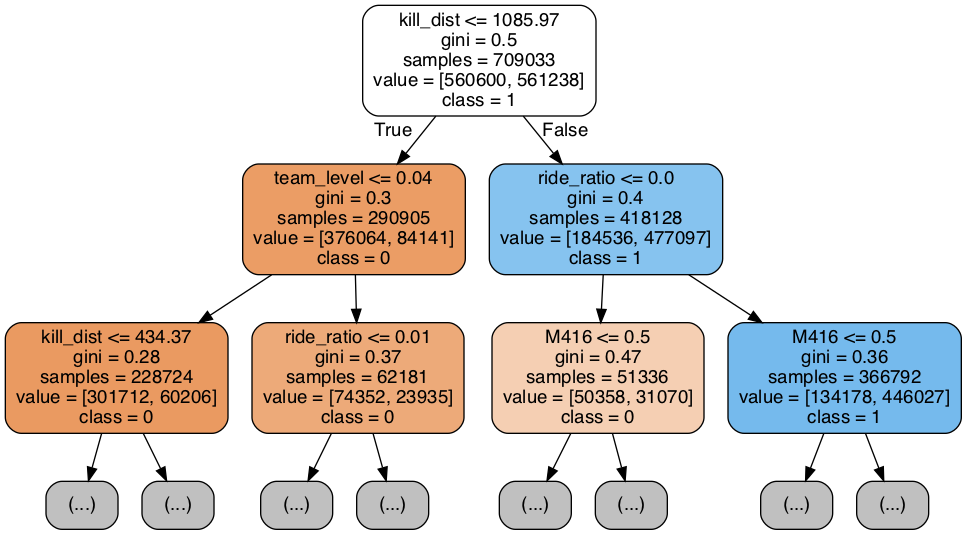

In [86]:
Image(graph_2.create_png(), retina=True)

## Train

In [87]:
pred_train_y = forest_clf.predict(train_x) 

### Confusion matrix

In [88]:
confusion_matrix(train_y, pred_train_y)

array([[433869, 127050],
       [ 73391, 487528]])

In [89]:
# Accuracy

accuracy_score(train_y, pred_train_y)

0.8213280348856073

In [90]:
# Precision

precision_score(train_y, pred_train_y)

0.7932727822993989

In [91]:
# Recall

recall_score(train_y, pred_train_y)

0.8691593616903689

In [92]:
# F1 Score

f1_score(train_y, pred_train_y)

0.8294840395169022

### Precision recall curve

In [93]:
train_y_scores = forest_clf.predict_proba(train_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(train_y, train_y_scores)
len(precisions), len(recalls), len(thresholds)

(229721, 229721, 229720)

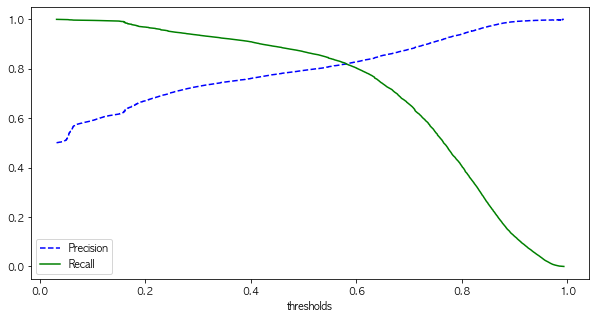

In [94]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

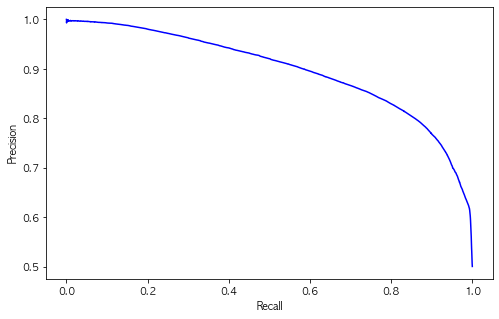

In [95]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [96]:
fpr, tpr, thresholds = roc_curve(train_y, train_y_scores)

In [97]:
# MAC 기준
# Window font: 'Malgun Gothic'

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

Text(0, 0.5, '진짜 양성 비율(TPR, 재현율)')

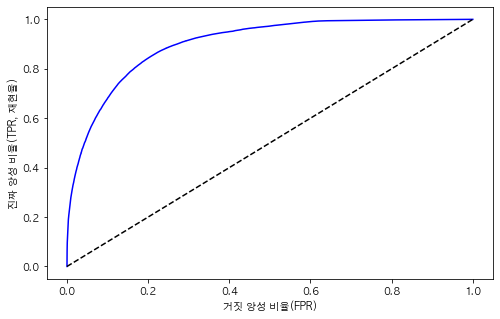

In [98]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

In [99]:
# AUC 계산

roc_auc_score(train_y, train_y_scores)

0.9023108259757848

## Test

In [100]:
pred_y = forest_clf.predict(test_x) 

### Confusion matrix

In [103]:
confusion_matrix(test_y, pred_y)

array([[1477177,  432497],
       [  31710,  208525]])

In [102]:
confusion_matrix(train_y, pred_train_y)

array([[433869, 127050],
       [ 73391, 487528]])

In [105]:
# Test Accuracy

accuracy_score(test_y, pred_y)

0.7840806285289285

In [107]:
# Test Precision

precision_score(test_y, pred_y)

0.325300847708815

In [109]:
# Test Recall

recall_score(test_y, pred_y)

0.8680042458426125

In [111]:
# Test F1 Score

f1_score(test_y, pred_y)

0.47324446784536184

### Precision  recall curve 

In [112]:
y_scores = forest_clf.predict_proba(test_x)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)
len(precisions), len(recalls), len(thresholds)

(264074, 264074, 264073)

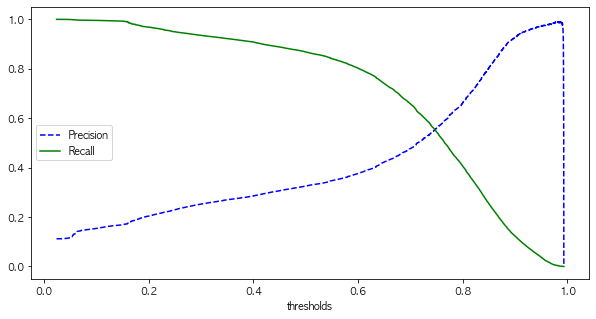

In [113]:
plt.figure(figsize=(10,5))
plot1, = plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plot2, = plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel("thresholds")
plt.legend()

Text(0, 0.5, 'Precision')

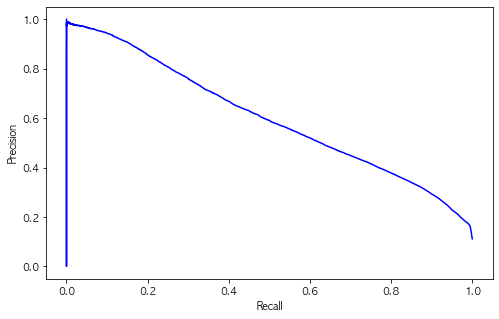

In [114]:
plt.figure(figsize=(8, 5))
plot1, = plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.xlim((0, 1))
# plt.ylim((0, 1))

### ROC curve

In [115]:
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

(0.0, 1.0)

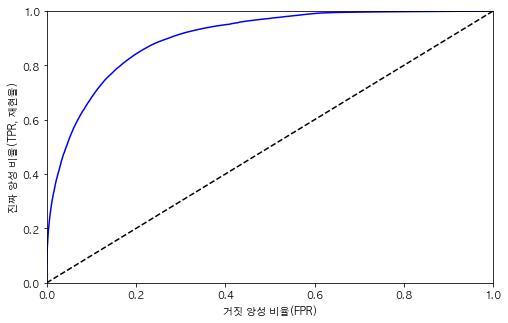

In [116]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('거짓 양성 비율(FPR)')
plt.ylabel('진짜 양성 비율(TPR, 재현율)')
plt.xlim((0, 1))
plt.ylim((0, 1))

In [117]:
# AUC 계산

roc_auc_score(test_y, y_scores)

0.901864746318118

## Feature Importance

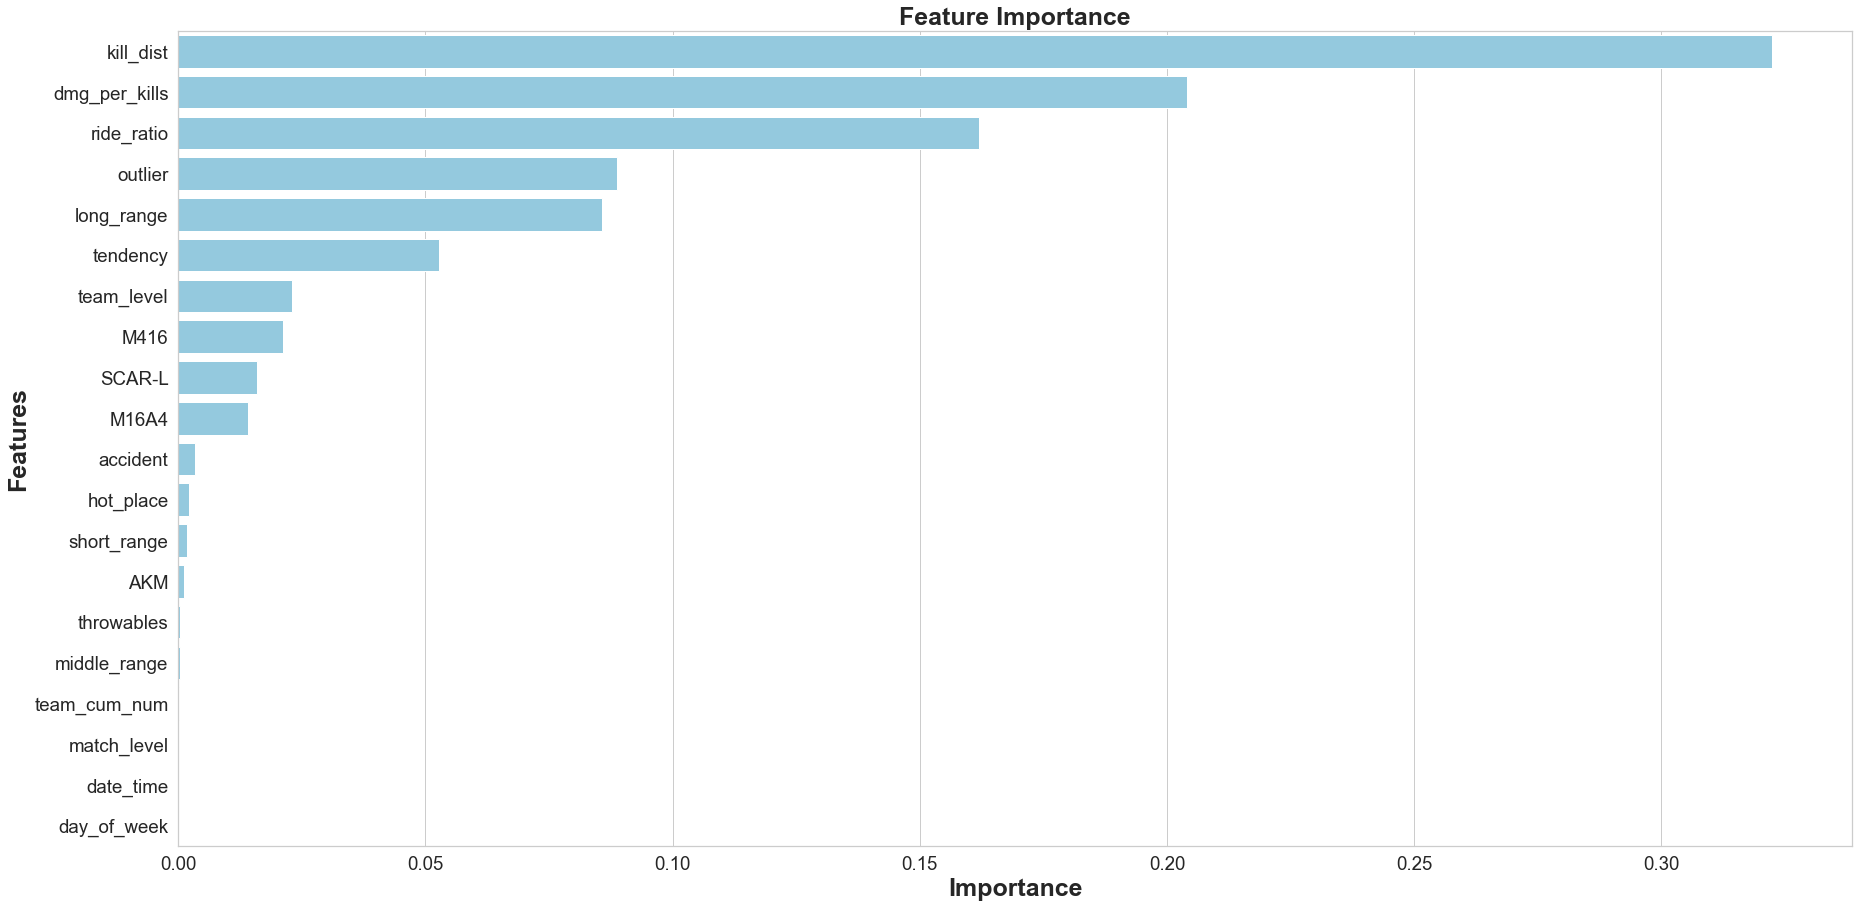

None

,Features,Gini-Importance
0,kill_dist,0.322
1,dmg_per_kills,0.204
2,ride_ratio,0.162
3,outlier,0.089
4,long_range,0.086
5,tendency,0.053
6,team_level,0.023
7,M416,0.021
8,SCAR-L,0.016
9,M16A4,0.014


In [118]:
feats = {}
for feature, importance in zip(X.columns.tolist(), forest_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index' : 'Features'})
sns.set(font_scale=5)
sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Feature Importance', fontsize=25, weight='bold')
display(plt.show())
display(importances)

## 비교

### Train

In [ ]:
confusion_matrix(train_y, pred_train_y)

In [ ]:
accuracy_score(train_y, train_y_scores)
roc_auc_score(train_y, train_y_scores)

### Test

In [ ]:
confusion_matrix(test_y, pred_y)

In [ ]:
accuracy_score(test_y, y_scores)
roc_auc_score(test_y, y_scores)

# Dimensionality Reduction

In [202]:
X.columns

Index(['day_of_week', 'date_time', 'match_level', 'team_level', 'team_cum_num',
       'outlier', 'dmg_per_kills', 'hot_place', 'kill_dist', 'tendency',
       'ride_ratio', 'M416', 'M16A4', 'SCAR-L', 'AKM', 'short_range',
       'middle_range', 'long_range', 'accident', 'throwables'],
      dtype='object')

In [205]:
new_X = X[['kill_dist', 'dmg_per_kills', 'ride_ratio', 'long_range', 'outlier', 'tendency', 
          'M416', 'SCAR-L', 'team_level', 'M16A4']]

In [206]:
reduced_cols = ['kill_dist', 'dmg_per_kills', 'ride_ratio', 'long_range', 'outlier', 'tendency', 
          'M416', 'SCAR-L', 'team_level', 'M16A4']

In [207]:
new_train_x = train_x[reduced_cols]
new_test_x = test_x[reduced_cols]

In [210]:
forest_clf.fit(new_train_x, train_y)

RandomForestClassifier(max_depth=7, min_samples_leaf=12, n_estimators=10,
                       random_state=42)

## Train

In [215]:
new_pred_train_y = forest_clf.predict(new_train_x)

In [217]:
confusion_matrix(train_y, new_pred_train_y)

array([[432516, 128403],
       [ 72171, 488748]])

In [218]:
# Accuracy

accuracy_score(train_y, new_pred_train_y)

0.821209479443556

In [219]:
# Precision

precision_score(train_y, new_pred_train_y)

0.7919423285387207

In [220]:
# Recall

recall_score(train_y, new_pred_train_y)

0.8713343637851454

In [221]:
# F1 Score

f1_score(train_y, new_pred_train_y)

0.8297435636252516

## Test

In [223]:
new_pred_y = forest_clf.predict(new_test_x) 

In [224]:
confusion_matrix(test_y, new_pred_y)

array([[1472361,  437313],
       [  31161,  209074]])

In [225]:
# Accuracy

accuracy_score(test_y, new_pred_y)

0.7820958933610679

In [227]:
# Precision

precision_score(test_y, new_pred_y)

0.32345019315054296

In [228]:
# Recall

recall_score(test_y, new_pred_y)

0.8702895081898974

In [229]:
# F1 Score

f1_score(test_y, new_pred_y)

0.47161924698462254